# HANK Tutorial

The package supports heterogeneous agent models. So far only one distribution is implemented.

The provided example is the same model as used by Auclert et al., 2022, which is documented [in a notebook here](https://github.com/shade-econ/sequence-jacobian/blob/master/notebooks/hank.ipynb) and given in the appendix of their paper. 
There are some deviations. First, the NK-Phillips Curve is the conventional nonlinear Phillips Curve as derived from Rothemberg pricing,
 $$
     \psi\left(\frac{\pi_t}{\pi_{SS}} - 1\right)\frac{\pi_t}{\pi_{SS}} = (1-\theta) + \theta w_t + E_t\left\{ \psi \beta_{t+1} \frac{C_t}{C_{t+1}}\left(\frac{\pi_{t+1}}{\pi_{SS}} - 1\right) \frac{\pi_{t+1}}{\pi_{SS}}\frac{Y^p_{t+1}}{Y^p_t}\right\}.
 $$
 
Second, the central bank sets the *shadow rate* to follow a conventional monetary policy rule with interest rate inertia,
$$
    R_{s,t} = \left[R^*\left(\frac{\pi_t}{\pi_{SS}}\right)^{\phi_\pi} \left(\frac{Y_t}{Y_{t-1}}\right)^{\phi_y}\right]^{1-\rho} R_{s,t-1}^\rho,
$$

and the actual nominal interest rate equals this *shadow rate* subject to the zero lower bound on nominal interest rates,
$$
R_t = \max\left\{1, R_{s,t}\right\}
$$

Details can be found in the section on the `yaml` file [above](https://econpizza.readthedocs.io/en/latest/tutorial.html#the-yaml-file>).

Start with some misc imports:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
# only necessary if you run this in a jupyter notebook

import jax.numpy as jnp # use jax.numpy instead of normal numpy. Yes, this is one of the reasons why it is nice not to have all numpy objects imported on the lowest hirarchy

Let's load the package and the example file:

In [2]:
import econpizza as ep
from econpizza import example_hank

`example_hank` is nothing else than the path to the yaml file we discussed before:

In [3]:
print(example_hank)

/home/gboehl/github/econpizza/econpizza/examples/hank.yaml


Parse the example hank model from the yaml and compile the model:

In [4]:
# parse model
mod_dict = ep.parse(example_hank)
# compile the model
mod = ep.load(mod_dict)

(load:) Parsing done.


The first step creates a raw dictionary from the yaml. The second translates everything to a model instance with compiled and tested functions. If something specific in your model does not work, you should have been informed by now.

Lets continue with the steady state:

In [5]:
stst_result = mod.solve_stst()

    Iteration   1 | max error 7.45e-01 | lapsed 5.8502
    Iteration   2 | max error 1.74e-01 | lapsed 6.3706
    Iteration   3 | max error 8.49e-02 | lapsed 6.8077
    Iteration   4 | max error 1.42e-02 | lapsed 7.2415
    Iteration   5 | max error 7.03e-08 | lapsed 7.6985
    Iteration   6 | max error 5.84e-11 | lapsed 8.1265
(solve_stst:) Steady state error is 7.06e-08. The solution converged. Jacobian has rank 12 for 18 variables (6 fixed). 


By default, the final message is rather verbose. The rank of the Jacobian is important because quite often, the steady state is indetermined and you need to fix some steady state values. Econpizza can deal with that by using the Pseudoinverse during the Newton steps. Fixing some of the variables is also what I did here. Since the function has 12 degrees of freedom and 6 fixed variables for a total of 18 variables, we're fine to go and the steady state solver nicely converges.

The resulting `stst_result` is similar to the return object from `scipy.optimize.root` and contains all sorts of nice information to help you debugging if you have problems finding the steady state:

In [6]:
print(stst_result.keys())

dict_keys(['success', 'message', 'x', 'niter', 'fun', 'jac', 'det'])


In [7]:
print(stst_result['fun']) # the steady state function at the solution x

[-7.05779770e-08 -1.11022302e-16  0.00000000e+00  3.52889032e-08
 -7.05778066e-08  3.52889032e-08  7.05779752e-08 -1.22124533e-14
 -6.69930778e-12 -3.34962573e-11  0.00000000e+00  7.05778065e-08
  1.41194612e-10 -5.88147812e-08  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


The Pizza automatically stores the steady state values as a dictionary in the model object:

In [8]:
mod['stst']

{'B': DeviceArray(5.6, dtype=float64),
 'beta': DeviceArray(0.98505158, dtype=float64),
 'C': DeviceArray(1.00000007, dtype=float64),
 'Div': DeviceArray(0.16666656, dtype=float64),
 'L': DeviceArray(1., dtype=float64),
 'pi': DeviceArray(1., dtype=float64),
 'R': DeviceArray(1.002, dtype=float64),
 'Rn': DeviceArray(1.002, dtype=float64),
 'Rs': DeviceArray(1.002, dtype=float64),
 'Rstar': DeviceArray(1.002, dtype=float64),
 'Tax': DeviceArray(0.01120007, dtype=float64),
 'Top10A': DeviceArray(0.42605587, dtype=float64),
 'Top10C': DeviceArray(0.29537923, dtype=float64),
 'vphi': DeviceArray(0.78656264, dtype=float64),
 'w': DeviceArray(0.83333333, dtype=float64),
 'Y': DeviceArray(1., dtype=float64),
 'Yprod': DeviceArray(0.99999996, dtype=float64),
 'Z': DeviceArray(1., dtype=float64)}

Let us, out of curiousity, have a look at the steady state distribution. It is stored under `mod['steady_state']`. Note that at the same location, also steady state `decisions` (the value function) are stored.

In [9]:
dist = mod['steady_state']['distributions'][0]
grid = mod['context']['a_grid']

Under the dict behind the `context` keyword, many other model specific variables are stored. Better have a look youself if you care. Lets plot the distribution:

(<Axes3DSubplot:>,
 (DeviceArray([1, 2, 3, 4], dtype=int64),
  DeviceArray([0.00000000e+00, 4.15327171e-02, 8.99653005e-02,
               1.46444031e-01, 2.12305622e-01, 2.89108857e-01,
               3.78671479e-01, 4.83113218e-01, 6.04905954e-01,
               7.46932222e-01, 9.12553438e-01, 1.10568945e+00,
               1.33091132e+00, 1.59354949e+00, 1.89981996e+00,
               2.25697142e+00, 2.67345676e+00, 3.15913317e+00,
               3.72549542e+00, 4.38594793e+00, 5.15612198e+00,
               6.05424572e+00, 7.10157554e+00, 8.32289917e+00,
               9.74712235e+00, 1.14079530e+01, 1.33446988e+01,
               1.56031979e+01, 1.82369035e+01, 2.13081488e+01,
               2.48896228e+01, 2.90660901e+01, 3.39363977e+01,
               3.96158136e+01, 4.62387558e+01, 5.39619732e+01,
               6.29682554e+01, 7.34707590e+01, 8.57180527e+01,
               1.00000000e+02], dtype=float64)))

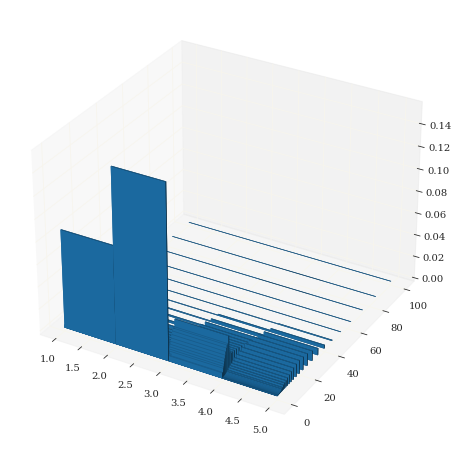

In [10]:
from grgrlib import grbar3d # a nice backend to 3D-plots with matplotlib

grbar3d(dist, xedges=jnp.arange(1,5), yedges=grid, figsize=(9,8), depth=.5)

Nice. Okay, let's continue to calculate some impulse response functions. We'll have a look at a shock to the households' discount factor $\beta$. Take the steady state as the initial value, and alter the value of $\beta$:

In [11]:
# this is a dict containing the steady state values
x0 = mod['stst'].copy()
# setting a shock on the discount factor
x0['beta'] = 0.99

Find the IRFs:

In [12]:
xst, _, flags = mod.find_stack(x0.values(), horizon=100, tol=1e-8)

(find_path_stacked:) Solving stack (size: 1800)...
    Iteration   1 | max error 4.01e-02 | lapsed 9.7575
    Iteration   2 | max error 4.64e-03 | lapsed 13.6562
    Iteration   3 | max error 9.58e-06 | lapsed 17.5567
(find_path_stacked:) Stacking done after 25.709 seconds. The solution converged.


That went smoothly. Again, you will get meaningful and (hopefully) infomative final messages. Let's plot only a few of the variables for space restrictions: output $y_t$ (`Y`), inflation $\pi_t$ (`pi`), the nominal interst rate $R_t$ (`Rn`), and the percentage share of wealth held by the top-10% richest, `Top10A`.

([<Figure size 576x432 with 4 Axes>],
 [<AxesSubplot:title={'center':'Y'}>,
  <AxesSubplot:title={'center':'pi'}>,
  <AxesSubplot:title={'center':'Rn'}>,
  <AxesSubplot:title={'center':'Top10A'}>],
 [[[<matplotlib.lines.Line2D at 0x7f10ec18dd80>],
   [<matplotlib.lines.Line2D at 0x7f10ec18e5f0>]]])

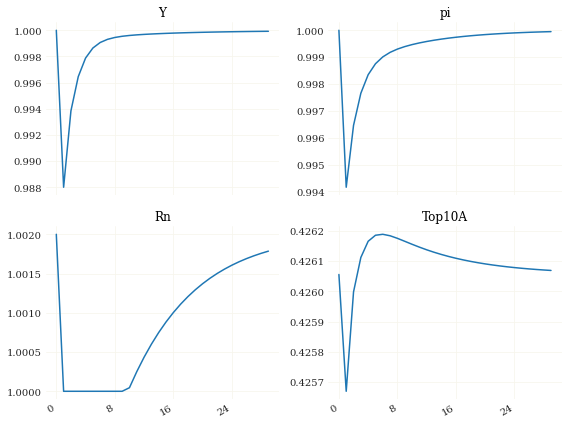

In [13]:
from grgrlib import grplot # a nice backend for batch plotting with matplotlib

# this is how all aggregate variables could be plotted:
#grplot(xst[:30], labels=mod['variables']) 

variables = 'Y', 'pi', 'Rn', 'Top10A'
inds = [mod['variables'].index(v) for v in variables] # get indices of variables

grplot(xst[:30, inds], labels=variables)

See how the effective lower bound is binding for 10 periods! The endogenous distribution adjusts accordingly. 

This end this short tutorial. Further details on the implementation of heterogeneous agent models are given [in the technical section](https://econpizza.readthedocs.io/en/latest/method.html).